Lab 4: Lexicon-based text classification
==================

In [1]:
# python 2 compatibility
from __future__ import print_function

We'll get data and sentiment lexicons from nltk (natural language toolkit)

In [2]:
! pip3 install --user nltk

    100% |████████████████████████████████| 1.2MB 61kB/s ta 0:00:011
  Running setup.py install for nltk ... done


In [3]:
import nltk

In [4]:
nltk.download('opinion_lexicon')

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/shawnramirez/nltk_data...
[nltk_data]   Unzipping corpora/opinion_lexicon.zip.


True

# Using the opinion lexicon

In [5]:
from nltk.corpus import opinion_lexicon

In [6]:
opinion_lexicon.positive()

['a+', 'abound', 'abounds', 'abundance', 'abundant', ...]

In [7]:
opinion_lexicon.negative()

['2-faced', '2-faces', 'abnormal', 'abolish', ...]

**Your turn**: think of three positive and negative sentiment words. See if they are in the lexicons.

In [8]:
# replace with your own words
my_pos = ['good','great','groovy']
my_neg = ['sick','demented','nasty']

In [9]:
# run this to see if they are in the lexicons
for lex in [my_pos,my_neg]:
    for word in lex:
        print(word,word in opinion_lexicon.positive(),word in opinion_lexicon.negative())

good True False
great True False
groovy False False
sick False True
demented False False
nasty False True


# Loading tweets

We'll use the data from the `Semeval 2017` shared task on sentiment analysis. 

http://alt.qcri.org/semeval2017/task4/

In [11]:
import pandas as pd

In [12]:
df = pd.read_csv('twitter-2015train-A.txt',delimiter='\t',names=['tweet_ID','label','text'])

In [13]:
df.head()

,tweet_ID,label,text
0,105121481662541824,negative,I forgot how sad the first episode of the 5th ...
1,104319460143415296,negative,Oct. 2 is almost too far away for me to wait f...
2,103641916586999808,neutral,(OFF TOPIC) - there is only 3 episodes on the ...
3,100544750414864384,neutral,@iheardavoicesay is finally catching up to me ...
4,102220476499243008,neutral,"I downloaded the first season of #Dexter, gonn..."


We need to break each tweet into **tokens**. To do this, we use a tokenizer.

In [14]:
from nltk.tokenize import TweetTokenizer

In [15]:
tokenizer = TweetTokenizer()

In [16]:
# tweet tokenization
print(df.loc[121].text)
print(tokenizer.tokenize(df.loc[121].text))

@lilyeliza1 Bruce Willis\u002c Bill Murray and Ed Norton all in the same film. I may faint.
['@lilyeliza1', 'Bruce', 'Willis', '\\', 'u002c', 'Bill', 'Murray', 'and', 'Ed', 'Norton', 'all', 'in', 'the', 'same', 'film', '.', 'I', 'may', 'faint', '.']


In [17]:
# whitespace tokenization
print(df.loc[121].text.split())

['@lilyeliza1', 'Bruce', 'Willis\\u002c', 'Bill', 'Murray', 'and', 'Ed', 'Norton', 'all', 'in', 'the', 'same', 'film.', 'I', 'may', 'faint.']


**Discuss**: what are the differences between these two tokenizations?

## Counting tokens

In [18]:
# here is a function to count the tokens in a tweet against a lexicon
def count_words(text,lex_list):
    assert(type(lex_list) == list)
    tokens = [token.lower() for token in tokenizer.tokenize(text)]
    return [len([token for token in tokens if token in lex]) for lex in lex_list]

This function turned out to be too slow on the full data

In [19]:
%%timeit
count_words(df.loc[121].text,[opinion_lexicon.negative()])

1 loop, best of 3: 368 ms per loop


In [20]:
len(df)

489

$146ms * 489 \approx 70 s$ -- too slow!

In [21]:
# this function uses set intersection instead
def count_words_sets(text,lex_list):
    assert(type(lex_list) == list)
    tokens = set([token.lower() for token in tokenizer.tokenize(text)])
    return [len(tokens.intersection(lex)) for lex in lex_list]

In [22]:
neg_set = set(opinion_lexicon.negative())

In [23]:
count_words_sets(df.loc[121].text,[neg_set])

[1]

In [24]:
%%timeit
count_words_sets(df.loc[121].text,[neg_set])

1000 loops, best of 3: 367 µs per loop


Much faster

**Your turn** Convert the positive lexicon into a set called `pos_set`, and run count_words_sets on the same message

In [25]:
# your code here
pos_set = set(opinion_lexicon.positive())

In [26]:
count_words_sets(df.loc[121].text,[pos_set])

[0]

Now let's add columns to the data frame for the positive and negative token counts

In [28]:
counts = [count_words(text,[pos_set,neg_set]) for text in df['text']]

In [29]:
df = df.assign(pos_words = [count[0] for count in counts])
df = df.assign(neg_words = [count[1] for count in counts])

In [30]:
df.head()

,tweet_ID,label,text,pos_words,neg_words
0,105121481662541824,negative,I forgot how sad the first episode of the 5th ...,0,1
1,104319460143415296,negative,Oct. 2 is almost too far away for me to wait f...,0,0
2,103641916586999808,neutral,(OFF TOPIC) - there is only 3 episodes on the ...,0,0
3,100544750414864384,neutral,@iheardavoicesay is finally catching up to me ...,0,0
4,102220476499243008,neutral,"I downloaded the first season of #Dexter, gonn...",0,0


Apply the following classification rule:
\begin{equation}
\hat{y}_i = 
\begin{cases}
\text{positive}, & \texttt{pos_words} > \texttt{neg_words}\\
\text{negative}, & \texttt{pos_words} < \texttt{neg_words}\\
\text{neutral}, & \texttt{pos_words} = \texttt{neg_words}
\end{cases}
\end{equation}

In [31]:
preds = pd.Series(['neutral'] * len(df))
preds[df['pos_words']>df['neg_words']] = 'positive'
preds[df['pos_words']<df['neg_words']] = 'negative'

**Your turn**: Use `df.assign` to add a column to the table called `prediction`, reflecting the predictions of this classifier.

In [32]:
# your code here
df = df.assign(prediction = preds)

In [33]:
b

,tweet_ID,label,text,pos_words,neg_words,prediction
0,105121481662541824,negative,I forgot how sad the first episode of the 5th ...,0,1,negative
1,104319460143415296,negative,Oct. 2 is almost too far away for me to wait f...,0,0,neutral
2,103641916586999808,neutral,(OFF TOPIC) - there is only 3 episodes on the ...,0,0,neutral
3,100544750414864384,neutral,@iheardavoicesay is finally catching up to me ...,0,0,neutral
4,102220476499243008,neutral,"I downloaded the first season of #Dexter, gonn...",0,0,neutral


# Measuring classifier performance

Let's first compute the accuracy

In [34]:
acc=(df['prediction']==df['label']).mean()
print('Accuracy: %.4f'%acc)

Accuracy: 0.5481


Is this good? A weak baseline is the frequency of the most common label. 

**Your turn** Compute the frequency of each label.

In [50]:
# your code here
sum(df.prediction=='positive')

172

In [51]:
sum(df.prediction=='negative')

126

In [49]:
sum(df.prediction=='neutral')

191

In [55]:
#frequency of the most common label (neutral?)
191/(172+126+191)

0.39059304703476483

Now let's compute the recall and precision, for the positive and negative classes.

In [53]:
tp = sum((df['label']=='positive') & (df['prediction']=='positive'))
fp = sum((df['label']!='positive') & (df['prediction']=='positive'))

In [54]:
prec = tp/(tp+fp)
print('precision: %.3f'%(prec))

precision: 0.593


**Your turn**: compute the recall for the positive class

In [127]:
# your code here
#accuracy: total number of the true positives predicted accurately plus true negatives predicated accurately, over the total
#recall: percent of the positives predicted correctly out of the total positive cases
#precision: percent of the positive predictions correct of the total predicted positive 
totpos =  sum(df['label']=='positive')
print(totpos)

170


In [122]:
rec = tp/totpos
print('recall: %.3f'%(rec))

recall: 0.600


In [123]:
f1 = 2 * prec * rec / (prec + rec)
print('f1: %.3f'%(f1))

f1: 0.596


**Your turn**: compute recall, precision, and F1 for the negative class.

In [124]:
# your code here. should be p = .31, r = .36
tn = sum((df['label']=='negative') & (df['prediction']=='negative'))
fn = sum((df['label']!='negative') & (df['prediction']=='negative'))
totneg = sum(df['label']=='negative')

In [125]:
precn = tn/(tn+fn)
print('precision: %.3f'%(prec))

precision: 0.593


In [126]:
recn = tn/totneg
print('recall: %.3f'%(rec))

recall: 0.600


# Sentiment over time

Let's try and replicate the Golder and Macy result about sentiment over time. 

Copy or link in the `ebola-tweets-short.json` file from lab 2.

In [57]:
import json

In [58]:
dec = json.JSONDecoder()

In [59]:
with open('ebola-tweets-short.json') as fin:
    objs = [dec.decode(line) for line in fin]

In [60]:
df_tweets = pd.DataFrame(objs)

In [61]:
df_tweets.keys()

Index(['contributors', 'coordinates', 'created_at', 'entities',
       'extended_entities', 'favorite_count', 'favorited', 'filter_level',
       'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'lang', 'place',
       'possibly_sensitive', 'retweet_count', 'retweeted', 'retweeted_status',
       'source', 'text', 'timestamp_ms', 'truncated', 'user'],
      dtype='object')

In [62]:
counts_tw = [count_words(text,[pos_set,neg_set]) for text in df_tweets['text']]

In [63]:
counts_tw[:4]

[[0, 0], [0, 0], [0, 2], [1, 0]]

**Your turn** create columns `pos_count` and `neg_count` in `df_tweets`

In [128]:
# your code here
df_tweets = df_tweets.assign(pos_count = [count[0] for count in counts_tw])
df_tweets = df_tweets.assign(neg_count = [count[1] for count in counts_tw])

In [129]:
df_tweets['neg_count'].head()

0    0
1    0
2    2
3    0
4    0
Name: neg_count, dtype: int64

To compute the rate per hour, we also need the total number of tokens in each tweet.

In [130]:
num_toks = [len(tokenizer.tokenize(tweet)) for tweet in df_tweets['text']]

In [131]:
print(num_toks[:5])

[4, 8, 29, 8, 1]


In [132]:
df_tweets = df_tweets.assign(num_toks=num_toks)

## Time stamps

Now we need to handle the timestamps. These are stored in the `created_at` field in the json.

**Note**: unfortunately these are GMT. To replicate the Golder/Macy analysis, you'd have to convert to the user's own time zone, using the `user.utc_offset` field of the json object.

In [133]:
df_tweets['created_at'][1]

'Thu Aug 28 15:36:29 +0000 2014'

In [134]:
df_tweets['user'][1]['utc_offset']

-10800

In [135]:
df_tweets.created_at.dtype

dtype('O')

This means the 'created_at' field is just a string. We need to convert to a structured object, `datetime`

In [136]:
from datetime import datetime
import re

First, remove the +0000, which marks the number of milliseconds. Regexp from 
https://stackoverflow.com/questions/41818264/convert-twitter-time-into-datetime-in-specific-format-to-count-frequency-of-twee

In [137]:
remove_ms = lambda x:re.sub("\+\d+\s","",x)

In [138]:
remove_ms(df_tweets['created_at'][1])

'Thu Aug 28 15:36:29 2014'

Now call datetime.strptime to convert to an object

In [139]:
date_obj = datetime.strptime(remove_ms(df_tweets['created_at'][1]),"%a %b %d %H:%M:%S %Y")

In [140]:
print(date_obj)

2014-08-28 15:36:29


Now we can get the hour

In [141]:
date_obj.hour

15

**Your turn**: add the hour as a column to the dataframe, `df_tweets['hour']`

In [171]:
# your code here

In [163]:
N = len(df_tweets['created_at'])

In [169]:
removed = [remove_ms(df_tweets['created_at'][val]) for val in range(N)]
print(removed) #this does the right thing

In [183]:
date_objnew = [datetime.strptime(remove_ms(df_tweets['created_at'][val]),"%a %b %d %H:%M:%S %Y") for val in range(N)]

In [185]:
print(date_objnew[1]) #this does the right thing too

2014-08-28 15:36:29


In [188]:
date_objnew[1].hour

15

In [189]:
hourslist = [date_objnew[val].hour for val in range(N)]

In [193]:
print(hourslist[1:30])

[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]


In [194]:
df_tweets = df_tweets.assign(hour = hourslist)

In [195]:
df_tweets['hour'].head()

0    15
1    15
2    15
3    15
4    15
Name: hour, dtype: int64

In [156]:
df_tweets['pos_count'].head()

0    0
1    0
2    0
3    1
4    0
Name: pos_count, dtype: int64

In [157]:
df_tweets['neg_count'].head()

0    0
1    0
2    2
3    0
4    0
Name: neg_count, dtype: int64

In [146]:
df_tweets['num_toks'].head()

0     4
1     8
2    29
3     8
4     1
Name: num_toks, dtype: int64

# Plots

Let's first aggregate by hour

In [196]:
df_agg = df_tweets.groupby('hour').aggregate('sum')[['pos_count','neg_count','num_toks']]

In [197]:
df_agg.head()

,pos_count,neg_count,num_toks
hour,,,
0,12.0,10.0,793.0
1,4.0,7.0,304.0
2,0.0,16.0,444.0
3,1.0,15.0,339.0
4,1.0,4.0,270.0


In this data frame, each entry is the sum over all tweets in that hour.

In [198]:
import matplotlib.pyplot as plt
%matplotlib inline

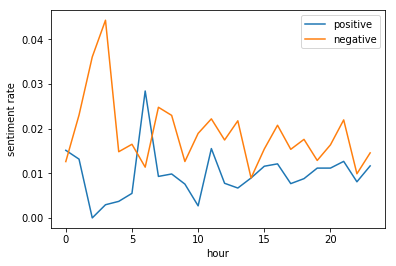

In [199]:
b

Pretty noisy, but it looks like sentiment is especially negative at 2-3AM GMT.

# Possible extensions

- Try the temporal analysis on more/different data
- Try other sentiment lexicons
- Compare various tokenizers
- Try lexicon expansion